# Copula Demo

Before running, make sure the requirements have been installed correctly.

In [1]:
import json

from jax import random
import jax
import jax.numpy as jnp

import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC, MixedHMC, DiscreteHMCGibbs
from numpyro.infer.reparam import TransformReparam
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from tqdm import tqdm

import matplotlib.pyplot as plt

/Users/danielmanela/.virtualenvs/causal-copulas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Sampling from `numpyro`

### What does `numpyro.sample` mean?
According to Numpyro's documentation, it simply returns a MC sample drawn from the input distribution. However, when contained within a Numpyro `model()` object which is passed to a Kernel, it also 

1. Defines the parameter in the posterior space
1. Adds the log-likelihood of the prior to the total log-posterior to be sampled.

Hence, these parameters can be defined by either a `sample()` based function, as below:

sample: 100%|█| 10500/10500 [00:04<00:00, 2306.27it/s, 1 steps of size 9.77e-01.


Mean: 0.010772526264190674. Var: 0.9858638644218445


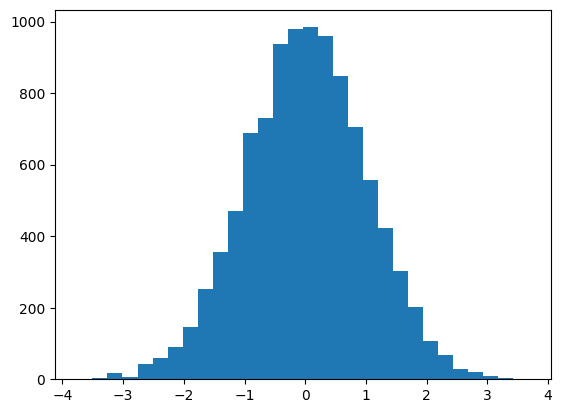

In [3]:
def sample_gaussian():
    # Need to initialise undefined variables with the `ImproperUniform()` object
    Z = numpyro.sample(
        'z', 
        dist.Normal(0, 1)
    )
    
sample_gaussian_kernel = NUTS(sample_gaussian)

sample_gaussian_mcmc = MCMC(
    sample_gaussian_kernel,
    num_warmup=500,
    num_samples=10000, 
    progress_bar=True
)
sample_gaussian_mcmc.run(random.PRNGKey(0))
plt.hist(np.array(sample_gaussian_mcmc.get_samples()['z']), bins=30);
print(f"Mean: {np.mean(sample_gaussian_mcmc.get_samples()['z'])}. Var: {np.var(sample_gaussian_mcmc.get_samples()['z'])}")

*Or* instead we can construct our log-posterior by simply adding the log-prior term using the `numpyro.factor()` command. This gives us the flexibility to use a variety of different functions and niche likelihoods that might not be found in the Numpyro Library. Below, we show how to sample from a Standard Gaussian using the factor approach. We still need to initialise the parameters we are sampling from, and can do so using wide Improper Uniform distributions (which assignes a value of 0 to every log-likelihood point in the space).

We see that both approaches sample from the same outcome!

sample: 100%|█| 10500/10500 [00:04<00:00, 2325.08it/s, 1 steps of size 9.77e-01.


Mean: 0.01068311557173729. Var: 0.9858933687210083


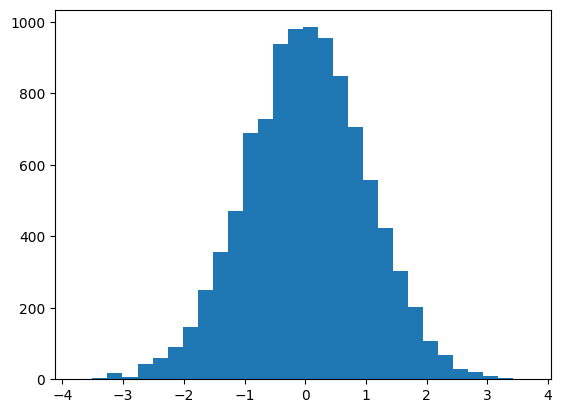

In [4]:
def std_gaussian(u):
    return -1 * jnp.square(u/jnp.sqrt(2))

def factor_gaussian():
    # Need to initialise undefined variables with the `ImproperUniform()` object
    Z = numpyro.sample(
        'z', 
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    numpyro.factor('gauss', std_gaussian(Z))
    
factor_gaussian_kernel = NUTS(factor_gaussian)

factor_gaussian_mcmc = MCMC(
    factor_gaussian_kernel,
    num_warmup=500,
    num_samples=10000, 
    progress_bar=True
)
factor_gaussian_mcmc.run(random.PRNGKey(0))
plt.hist(np.array(factor_gaussian_mcmc.get_samples()['z']), bins=30);
print(f"Mean: {np.mean(factor_gaussian_mcmc.get_samples()['z'])}. Var: {np.var(factor_gaussian_mcmc.get_samples()['z'])}")

## Didelez Model

We use the discrete/continuous model in Evans & Didelez as an example to illustrate our method.

In [5]:
def gaussian_copula_lpdf(u, v, rho):
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    return (
        -0.5 * (1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )


def base_didelez_model(y=None, 
                       a_const_sigmoid=0.,
                       alpha_0=0,
                       alpha_a=0,
                       gamma_0=0,
                       gamma_a=0,
                       gamma_l=0,
                       gamma_al=0,
                       beta_0=0,
                       beta_a=0,
                       beta_b=0,
                       beta_ab=0,
                       sigma_y=1):
    
    A = numpyro.sample("a", dist.Bernoulli(jax.nn.sigmoid(a_const_sigmoid)), sample_shape=())
    L_mu = numpyro.deterministic('l_mu', jnp.exp(-(alpha_0 + alpha_a * A)))
    L = numpyro.sample("l", dist.Exponential(L_mu), sample_shape=())
    quantiles_L = numpyro.deterministic('q_L', dist.Exponential(L_mu).cdf(L))
    
    B_prob = numpyro.deterministic(
        'b_prob', 
        jax.nn.sigmoid(
            gamma_0 + gamma_a * A + gamma_l * L + gamma_al * A * L
        )
    )
    B = numpyro.sample("b", dist.Bernoulli(B_prob), sample_shape=())    

    Y_mean = numpyro.deterministic('y_mean', beta_0 + beta_a * A + beta_b * B + beta_ab * A * B)
    Y = numpyro.sample("y", dist.Normal(Y_mean, sigma_y), sample_shape=())
    quantiles_Y = numpyro.deterministic('q_Y', dist.Normal(Y_mean, sigma_y).cdf(Y))    
    
    # Choosing an arbitrary sigmoidal function for rho_ly
    rho_LY_val = numpyro.deterministic('rho_ly', jax.nn.sigmoid(0.6 * (B + A)))
    
    # `numpyro.factor()` appears to add a log-likelihood to the sampling space
    # If you want to add the renormalising factors, we can simply add or subtract
    # log-likelihood factors similar to what we do on the line below.
    std_normal_L = numpyro.deterministic('std_normal_l', dist.Normal(0, 1).icdf(quantiles_L))
    std_normal_Y = numpyro.deterministic('std_normal_y', dist.Normal(0, 1).icdf(quantiles_Y))
    cop_log_prob = numpyro.factor('cop_log_prob', gaussian_copula_lpdf(std_normal_L, std_normal_Y, rho_LY_val))

Since this model contains a mixture of discrete and continuous parameters, we must use a hybrid sampler to do so. Numpyro has two alternatives:

1. [`MixedHMC`](https://num.pyro.ai/en/stable/mcmc.html#id15)
1. [`DiscreteHMCGibbs()`](https://num.pyro.ai/en/stable/mcmc.html#id12)

When the likelihood contains a copula term whose off-diagnonal terms are functions of the other parameter (not simply constants), the `MixedHMC` approach took a great deal of time and would not finish. The second `DiscreteHMCGibbs` alternative uses a HMC/NUTS sampler for the continuous parameters and Gibbs sampler for the discrete ones. This one works far better and draws samples in a reasonable amount of time.

In [6]:
base_didelez_kernel = DiscreteHMCGibbs(NUTS(base_didelez_model), modified=True)

To remain consistent with the format in the `R` `causl` package, we constructed the parameterisation for the Didelez model in a similar form as the `R` vignettes.

In [7]:
params = {
    'A': {'a_const_sigmoid': 0.},
    'L': {'alpha_0': 0.3, 'alpha_a': 0.2},
    'B': {'gamma_0': -0.3, 'gamma_a': 0.4, 'gamma_l': 0.3, 'gamma_al': 0},
    'Y': {'beta_0': -0.5, 'beta_a': 0.2, 'beta_b': 0.3, 'beta_ab': 0}
}

print(params)

{'A': {'a_const_sigmoid': 0.0}, 'L': {'alpha_0': 0.3, 'alpha_a': 0.2}, 'B': {'gamma_0': -0.3, 'gamma_a': 0.4, 'gamma_l': 0.3, 'gamma_al': 0}, 'Y': {'beta_0': -0.5, 'beta_a': 0.2, 'beta_b': 0.3, 'beta_ab': 0}}


These are saved as a json format and can be loaded in R as a list using the `rjson` package:

In [8]:
R_params = {}
for k, v in params.items():
    R_params[k] = {'beta': list(v.values())}

with open('didelez_params.json', 'w') as file:
    json.dump(R_params, file)
print(R_params)

{'A': {'beta': [0.0]}, 'L': {'beta': [0.3, 0.2]}, 'B': {'beta': [-0.3, 0.4, 0.3, 0]}, 'Y': {'beta': [-0.5, 0.2, 0.3, 0]}}


### Running the model

In [9]:
mcmc_didelez = MCMC(
    base_didelez_kernel,
    num_warmup=1000,
    num_samples=50000, 
    progress_bar=True
)

mcmc_didelez.run(
    random.PRNGKey(1),
    a_const_sigmoid=params['A']['a_const_sigmoid'],
    alpha_0=params['L']['alpha_0'],
    alpha_a=params['L']['alpha_a'],
    gamma_0=params['B']['gamma_0'],
    gamma_a=params['B']['gamma_a'],
    gamma_l=params['B']['gamma_l'],
    gamma_al=params['B']['gamma_al'],
    beta_0=params['Y']['beta_0'],
    beta_a=params['Y']['beta_a'],
    beta_b=params['Y']['beta_b'],
    beta_ab=params['Y']['beta_ab'],
    sigma_y=1
)
# mcmc_didelez.print_summary()  
didelez_samples = mcmc_didelez.get_samples()
pd.DataFrame(didelez_samples).describe()

sample: 100%|█| 51000/51000 [00:25<00:00, 1974.80it/s, 7 steps of size 4.17e-01.


,a,b,b_prob,l,l_mu,q_L,q_Y,rho_ly,std_normal_l,std_normal_y,y,y_mean
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.481540,0.560500,0.576199,1.476979,0.676153,0.497403,0.501991,0.645109,-0.012970,0.004059,-0.231483,-0.235542
std,0.499664,0.496331,0.107349,1.485212,0.067099,0.289167,0.290110,0.098678,1.003530,1.005039,1.036998,0.186804
min,0.000000,0.000000,0.425561,0.000013,0.606531,0.000008,0.000012,0.500000,-4.313420,-4.227647,-4.727647,-0.500000
25%,0.000000,0.000000,0.491653,0.418708,0.606531,0.246399,0.252740,0.500000,-0.685864,-0.665893,-0.933071,-0.500000
50%,0.000000,1.000000,0.559140,1.022295,0.740818,0.498085,0.503499,0.645656,-0.004801,0.008771,-0.230364,-0.200000
75%,1.000000,1.000000,0.636274,2.053511,0.740818,0.746810,0.754905,0.768525,0.664486,0.690006,0.472504,0.000000
max,1.000000,1.000000,0.993441,17.734213,0.740818,0.999998,0.999939,0.768525,4.614844,3.841931,3.596794,0.000000


#### Chains have mixed well

In [10]:
mcmc_didelez.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.48      0.50      0.00      0.00      1.00 222452.86      1.00
         b      0.56      0.50      1.00      0.00      1.00  88393.85      1.00
         l      1.48      1.49      1.02      0.00      3.39  15798.69      1.00
         y     -0.23      1.04     -0.23     -1.89      1.52  13325.10      1.00



### Saving the samlpes as a csv to be loaded into `R`

In [11]:
pd.DataFrame(didelez_samples).to_csv('didelez_samples_python.csv', index=False)

### Checking the copula is behaving sensibly

#### Quantiles for L and Y appear to be uniform
This gets thrown off a bit if the $\rho_{LY}$ parameter is very close to 1, but otherwise the quantiles appear uniform

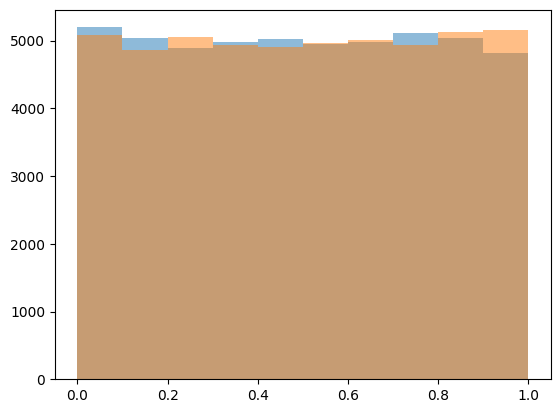

In [12]:
plt.hist(didelez_samples['q_L'], alpha=0.5);
plt.hist(didelez_samples['q_Y'], alpha=0.5);

#### Correlations observed for both the quantile plots

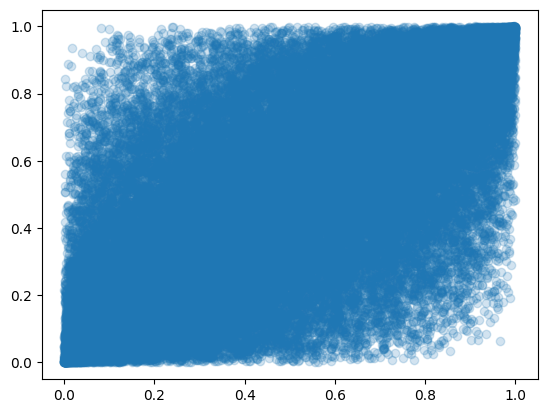

In [13]:
plt.scatter(didelez_samples['q_L'], didelez_samples['q_Y'], alpha=0.2)

#### and also the raw gaussian copula

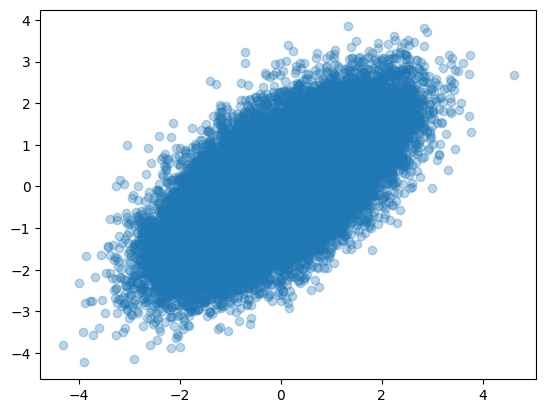

In [14]:
plt.scatter(didelez_samples['std_normal_l'], didelez_samples['std_normal_y'], alpha=0.3)

#### whose Empirical Sufficient Statistics agree with the theoretical expectation

In [15]:
np.mean(pd.DataFrame(didelez_samples)[['std_normal_l', 'std_normal_y']])

/Users/danielmanela/.virtualenvs/causal-copulas/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


std_normal_l   -0.012970
std_normal_y    0.004059
dtype: float32

In [16]:
np.cov(pd.DataFrame(didelez_samples)[['std_normal_l', 'std_normal_y']].T)

array([[1.00707313, 0.66015519],
       [0.66015519, 1.01010266]])

In [17]:
jax.nn.sigmoid(1.)

DeviceArray(0.7310586, dtype=float32, weak_type=True)

## Testing out performance time with high correlations

In this example we work with the following model:
$$Z~\sim~\mathcal{N}(0, 1) \\ X~|~Z~\sim~\mathcal{N}( \rho_{XZ} Z,~1 - \rho_{XZ}^{2}) \\ Y~|~\text{do}(X) \sim \mathcal{N}(X - 0.5,~1)$$
with a gaussian copula correlation of $\rho_{YZ}=\text{expit}(1)$.

### Centered vs. Non Centered Parameterisations
Sampling problems arise when dealing with highly correlated variables. In Hamiltonian Monte Carlo (HMC) and NUTS samplers, traverising across a highly correlated posterior results in either divergent transitions or very slow transition steps as transitions are generally calculated agnostic of _where_ in the posterior space they lie.

If $\rho_{XZ}$ is very close to 1 (say 0.99), by definition $X$ and $Z$ will be highly correlated and sampling will be inefficient. We can improve upon things by using a non-centered parameterisation, where we capture the same data generating setup as the centered parameterisation above. Through introducing two standard gaussian RVs $U_1, U_2$, we can do the following:

$$ Z~\sim~\mathcal{N}(0, 1) \\ \mathbf{U}~\sim~\mathcal{N}(\mathbf{0}, \mathbf{I}) \\ X~|~Z=\rho_{XZ}\cdot Z + (1-\rho_{XZ}^2)\cdot U_1) \\ Y~|~\text{do}(X) = X - 0.5 + U_2$$

The generating distributions are the same, but instead of sampling from highly correlated parameters, we sample from a multivariate standard Gaussian formed by $(Z,~U_1,~U_2)$.

**The function below allows you to sample from either using the** `noncentered_param` **arguement.**

In [18]:
def high_correlations(y=None, rho=0., centered_param=True):
    Z = numpyro.sample("z", dist.Normal(0, 1))
    
    if centered_param:
        X = numpyro.sample("x", dist.Normal(rho*Z, jnp.sqrt(1 - jnp.square(rho))))
        Y = numpyro.sample("y", dist.Normal(-0.5 + X, 1))
    else:
        U1 = numpyro.sample("u1", dist.Normal(0, 1))
        U2 = numpyro.sample("u2", dist.Normal(0, 1))        
        X = numpyro.deterministic("x", rho * Z + jnp.sqrt(1 - jnp.square(rho)) * U1)
        Y = numpyro.deterministic("y", X + U2 - 0.5)
    
    quantiles_Y = numpyro.deterministic('q_Y', dist.Normal(-0.5 + X, 1).cdf(Y))    
    quantiles_Z = numpyro.deterministic('q_Z', dist.Normal(0, 1).cdf(Z))
    
    # Choosing an arbitrary sigmoidal function for rho_ly
    rho_ZY_val = numpyro.deterministic('rho_ly', jax.nn.sigmoid(1.))
    
    std_normal_Z = numpyro.deterministic('std_normal_z', dist.Normal(0, 1).icdf(quantiles_Z))
    std_normal_Y = numpyro.deterministic('std_normal_y', dist.Normal(0, 1).icdf(quantiles_Y))
    # cop_log_prob = numpyro.factor('cop_log_prob', gaussian_copula_lpdf(std_normal_Z, std_normal_Y, rho_ZY_val))

In [19]:
def generate_samples(model, num_warmup, num_samples, rho, centered_param=False):
    kernel = NUTS(model)
    mcmc_model = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples, 
        progress_bar=True
    )
    mcmc_model.run(
        random.PRNGKey(1),
        rho=rho,
        centered_param=centered_param
    )
    mcmc_model.print_summary()
    return mcmc_model.get_samples()

Time to test across different types of $\rho_{XZ}$:

$$\rho_{XZ} \in \{0.5, 0.9, 0.99, 0.9999\}$$

### $\rho_{XZ} = 0.5$

In [20]:
centered_samples_rho_05 = generate_samples(high_correlations, num_warmup=500, num_samples=10000, rho=0.5, centered_param=True) 
noncentered_samples_rho_05 = generate_samples(high_correlations, num_warmup=500, num_samples=10000, rho=0.5, centered_param=False)

sample: 100%|█| 10500/10500 [00:05<00:00, 1931.03it/s, 3 steps of size 5.35e-01.



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.01      0.98      0.01     -1.50      1.67   4666.52      1.00
         y     -0.47      1.40     -0.49     -2.73      1.85   4416.14      1.00
         z      0.01      0.98      0.02     -1.56      1.64   5023.13      1.00

Number of divergences: 0


sample: 100%|█| 10500/10500 [00:05<00:00, 1942.48it/s, 3 steps of size 7.95e-01.



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.01      1.00      0.02     -1.64      1.65   8904.55      1.00
        u2      0.00      1.01      0.01     -1.68      1.65   9817.09      1.00
         z      0.01      0.98     -0.00     -1.65      1.58  10301.87      1.00

Number of divergences: 0


In [21]:
print(f"C Var: {jnp.var(centered_samples_rho_05['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['z'])}")

C Var: 0.9568050503730774
NC Var: 0.9691702127456665


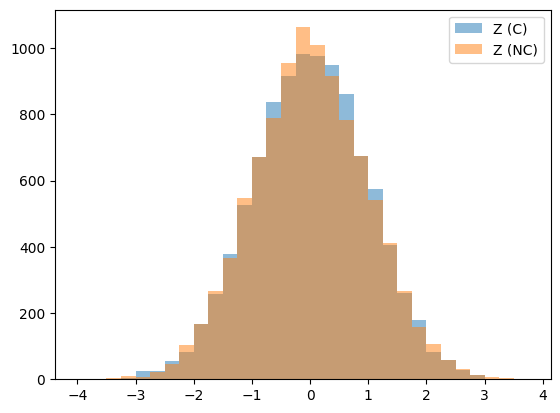

In [22]:
plt.hist(centered_samples_rho_05['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [23]:
print(f"C Var: {jnp.var(centered_samples_rho_05['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['x'])}")

C Var: 0.9530737996101379
NC Var: 0.994486927986145


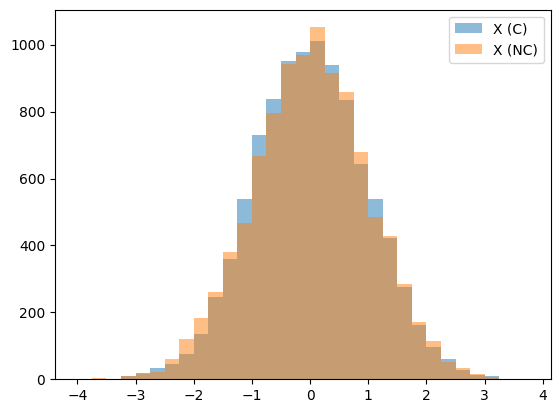

In [24]:
plt.hist(centered_samples_rho_05['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [25]:
print(f"C Var: {jnp.var(centered_samples_rho_05['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_05['y'])}")

C Var: 1.9642752408981323
NC Var: 1.9876972436904907


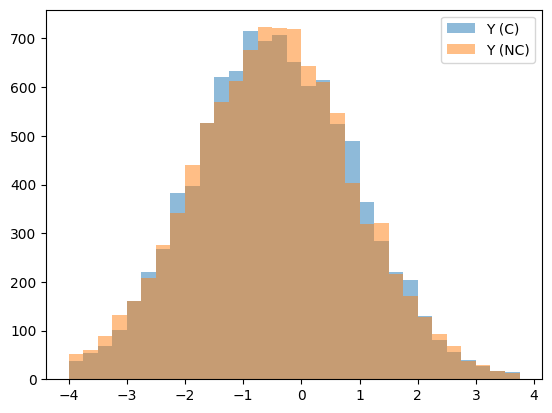

In [26]:
plt.hist(centered_samples_rho_05['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_05['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

### $\rho_{XZ} = 0.9$

In [27]:
centered_samples_rho_09 = generate_samples(high_correlations, num_warmup=500, num_samples=10000, rho=0.9, centered_param=True) 
noncentered_samples_rho_09 = generate_samples(high_correlations, num_warmup=500, num_samples=10000, rho=0.9, centered_param=False)

sample: 100%|█| 10500/10500 [00:05<00:00, 1949.45it/s, 7 steps of size 3.20e-01.



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.00      1.00     -0.01     -1.61      1.69   2334.75      1.00
         y     -0.49      1.43     -0.50     -2.97      1.76   2936.00      1.00
         z     -0.01      1.00      0.01     -1.64      1.66   2365.32      1.00

Number of divergences: 0


sample: 100%|█| 10500/10500 [00:05<00:00, 1937.51it/s, 3 steps of size 7.95e-01.



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.01      1.00      0.02     -1.64      1.65   8904.55      1.00
        u2      0.00      1.01      0.01     -1.68      1.65   9817.09      1.00
         z      0.01      0.98     -0.00     -1.65      1.58  10301.87      1.00

Number of divergences: 0


In [28]:
print(f"C Var: {jnp.var(centered_samples_rho_09['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['z'])}")

C Var: 1.003476619720459
NC Var: 0.9691702127456665


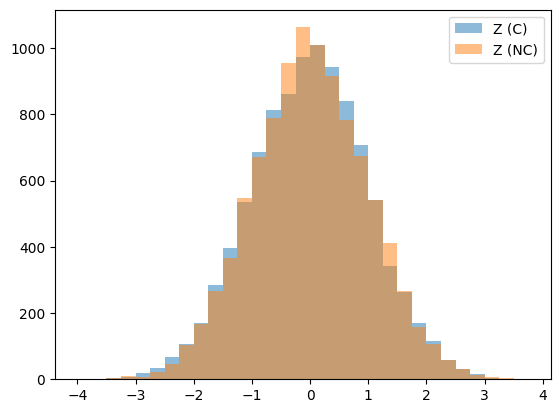

In [29]:
plt.hist(centered_samples_rho_09['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [30]:
print(f"C Var: {jnp.var(centered_samples_rho_09['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['x'])}")

C Var: 1.0055060386657715
NC Var: 0.9781541228294373


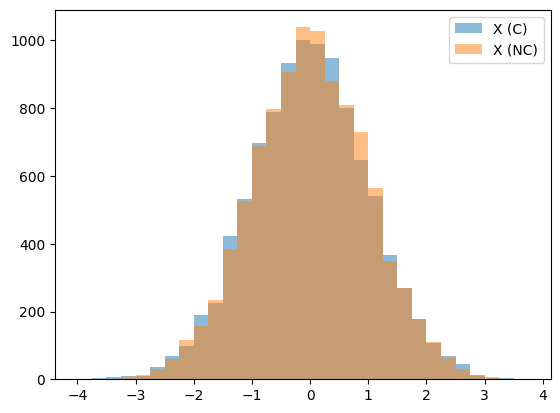

In [31]:
plt.hist(centered_samples_rho_09['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [32]:
print(f"C Var: {jnp.var(centered_samples_rho_09['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09['y'])}")

C Var: 2.050271987915039
NC Var: 1.9804372787475586


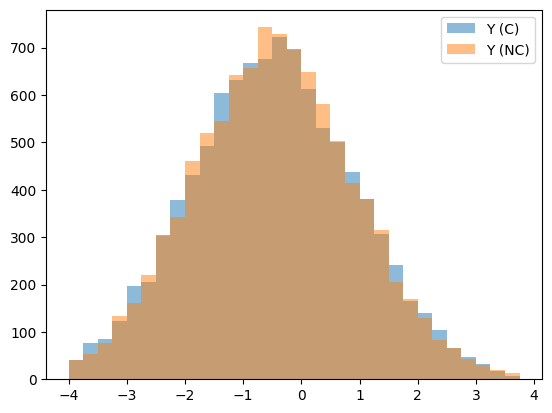

In [33]:
plt.hist(centered_samples_rho_09['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

### $\rho_{XZ} = 0.99$

In [34]:
centered_samples_rho_099 = generate_samples(high_correlations, num_warmup=500, num_samples=10000, rho=0.99, centered_param=True) 
noncentered_samples_rho_099 = generate_samples(high_correlations, num_warmup=500, num_samples=10000, rho=0.99, centered_param=False)

sample: 100%|█| 10500/10500 [00:05<00:00, 1924.40it/s, 15 steps of size 1.05e-01



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.01      0.99     -0.02     -1.64      1.58   2154.46      1.00
         y     -0.47      1.41     -0.45     -2.91      1.70   2488.46      1.00
         z     -0.01      0.99     -0.03     -1.62      1.61   2150.52      1.00

Number of divergences: 0


sample: 100%|█| 10500/10500 [00:05<00:00, 1958.23it/s, 3 steps of size 7.95e-01.



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.01      1.00      0.02     -1.64      1.65   8904.55      1.00
        u2      0.00      1.01      0.01     -1.68      1.65   9817.09      1.00
         z      0.01      0.98     -0.00     -1.65      1.58  10301.87      1.00

Number of divergences: 0


In [35]:
print(f"C Var: {jnp.var(centered_samples_rho_099['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['z'])}")

C Var: 0.9708960652351379
NC Var: 0.9691702127456665


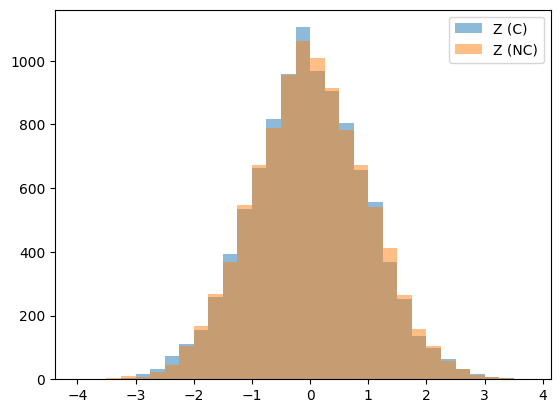

In [36]:
plt.hist(centered_samples_rho_099['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [37]:
print(f"C Var: {jnp.var(centered_samples_rho_099['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['x'])}")

C Var: 0.9704181551933289
NC Var: 0.9710075259208679


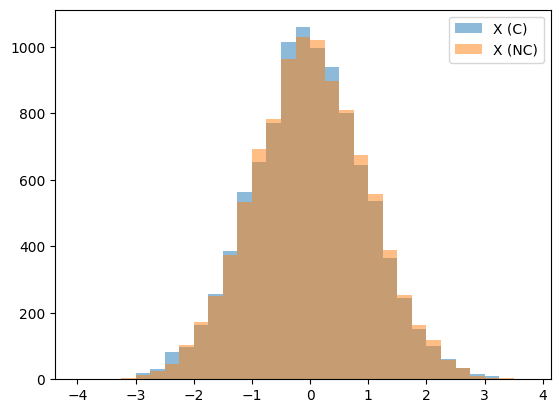

In [38]:
plt.hist(centered_samples_rho_099['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [39]:
print(f"C Var: {jnp.var(centered_samples_rho_099['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_099['y'])}")

C Var: 1.9826431274414062
NC Var: 1.9800211191177368


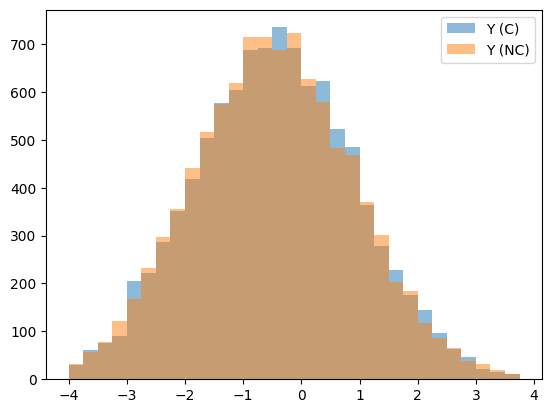

In [40]:
plt.hist(centered_samples_rho_099['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_099['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

### $\rho_{XZ} = 0.9999$

In [41]:
centered_samples_rho_09999 = generate_samples(high_correlations, num_warmup=500, num_samples=10000, rho=0.9999, centered_param=True) 
noncentered_samples_rho_09999 = generate_samples(high_correlations, num_warmup=500, num_samples=10000, rho=0.9999, centered_param=False)

sample: 100%|█| 10500/10500 [00:05<00:00, 1827.04it/s, 235 steps of size 1.09e-0



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.05      1.01     -0.03     -1.74      1.57   1389.73      1.00
         y     -0.55      1.42     -0.57     -2.96      1.70   1762.20      1.00
         z     -0.05      1.01     -0.03     -1.70      1.61   1391.26      1.00

Number of divergences: 0


sample: 100%|█| 10500/10500 [00:05<00:00, 1967.15it/s, 3 steps of size 7.95e-01.



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        u1      0.01      1.00      0.02     -1.64      1.65   8904.55      1.00
        u2      0.00      1.01      0.01     -1.68      1.65   9817.09      1.00
         z      0.01      0.98     -0.00     -1.65      1.58  10301.87      1.00

Number of divergences: 0


In [42]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['z'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['z'])}")

C Var: 1.0149232149124146
NC Var: 0.9691702127456665


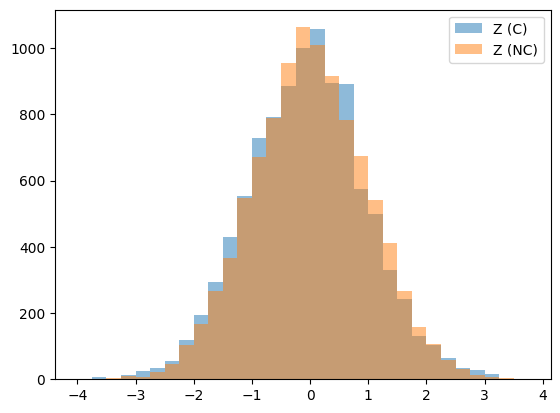

In [43]:
plt.hist(centered_samples_rho_09999['z'], alpha=0.5, label='Z (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['z'], alpha=0.5, label='Z (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend()

In [44]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['x'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['x'])}")

C Var: 1.0145530700683594
NC Var: 0.9693045616149902


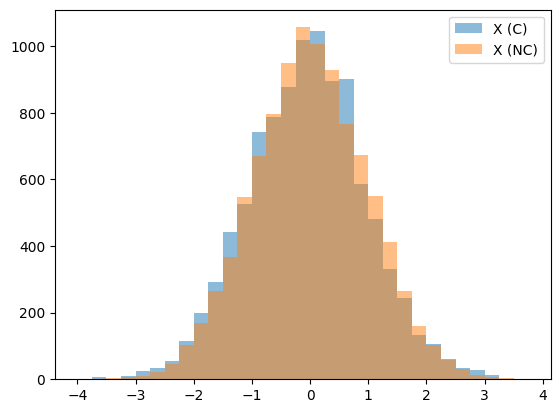

In [45]:
plt.hist(centered_samples_rho_09999['x'], alpha=0.5, label='X (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['x'], alpha=0.5, label='X (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();

In [46]:
print(f"C Var: {jnp.var(centered_samples_rho_09999['y'])}")
print(f"NC Var: {jnp.var(noncentered_samples_rho_09999['y'])}")

C Var: 2.006556749343872
NC Var: 1.9812954664230347


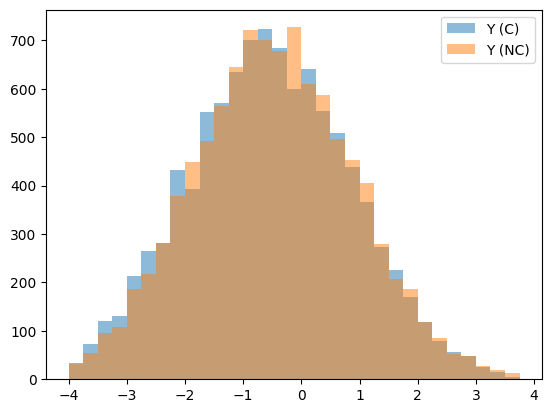

In [47]:
plt.hist(centered_samples_rho_09999['y'], alpha=0.5, label='Y (C)', bins=np.arange(-4, 4, 0.25));
plt.hist(noncentered_samples_rho_09999['y'], alpha=0.5, label='Y (NC)', bins=np.arange(-4, 4, 0.25));
plt.legend();